# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from data import data_path
from functional_neural_networks.dense import FunctionalDense
from functional_neural_networks.convolution import FunctionalConvolution
from hyperopt.sklearn_gridsearch import HyperOptScikitFda
from images import images_path
from shapley.shapley_fda import ShapleyFda
from skfda.datasets import fetch_tecator
from skfda.ml.regression import KNeighborsRegressor, LinearRegression
from skfda.representation.basis import BSplineBasis
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import train_test_split
from utils.utils_workflow import obtain_score, plot_shapley_function, plot_shapley_value, predict_from_np, predict_no_verbose_squeeze
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2025-03-04 12:32:02.927749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory

In [2]:
save_figures = False

In [3]:
data_output_path = os.path.join(data_path, "other")

In [4]:
original_size = [6.4, 4.8]
aspect_ratio = original_size[0]/original_size[1]
new_size = [10 * aspect_ratio, 10]

0.125 0.11


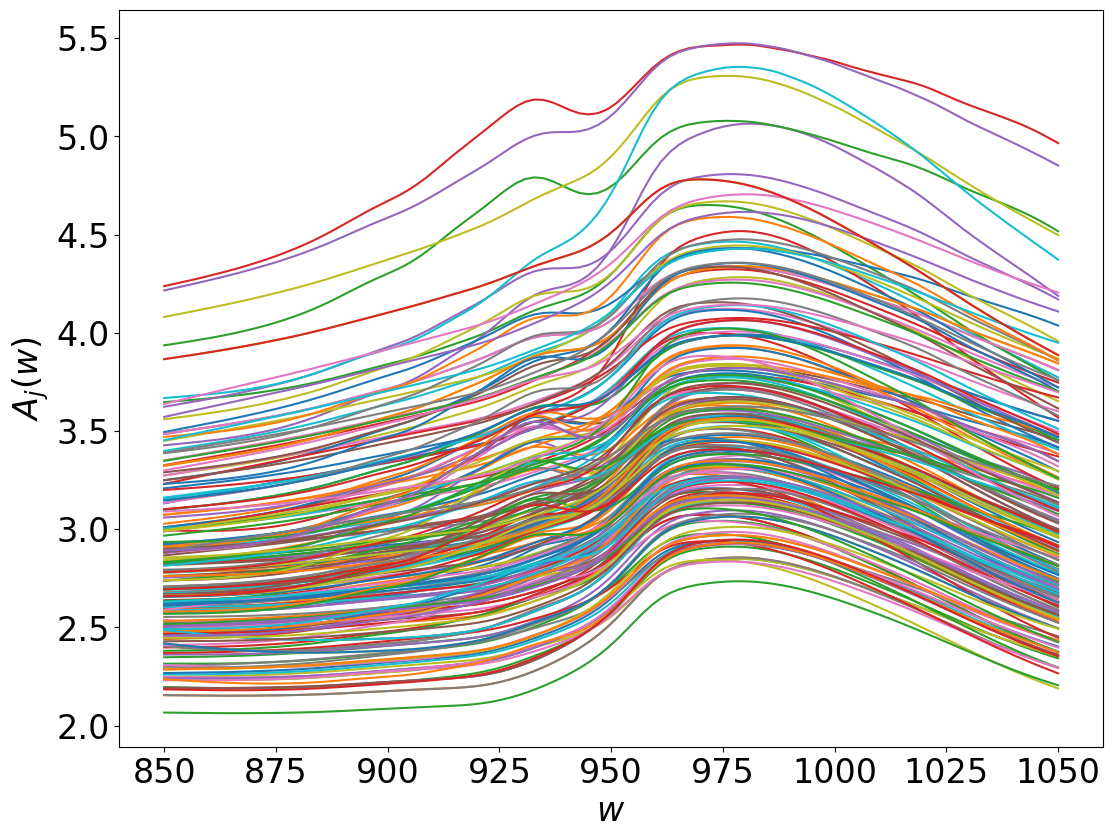

In [5]:
X, y = fetch_tecator(return_X_y=True, as_frame=True)
f = X.iloc[:, 0].values
fat = y["fat"].values
f.argument_names = None
f.coordinate_names = None
f.dataset_name = None
zzz = f.plot()
zzz.axes[0].tick_params(axis='x', labelsize=24)
zzz.axes[0].tick_params(axis='y', labelsize=24)
zzz.axes[0].set_xlabel(r"$w$", fontsize=24)
zzz.axes[0].set_ylabel(r"$A_j(w)$", fontsize=24)
zzz.figure.set_size_inches(new_size)
left = zzz.axes[0].figure.subplotpars.left
bottom = zzz.axes[0].figure.subplotpars.bottom
print(left, bottom)
zzz.figure.subplots_adjust(left=1.3 * left)
zzz.figure.subplots_adjust(bottom=1.3 * bottom)
zzz.figure.set_facecolor("none")
zzz.axes[0].set_facecolor("white")
if save_figures:
    zzz.figure.savefig(
        os.path.join(images_path, "tecator_raw_no_name.pdf"),
        format="pdf",
    )

In [6]:
if save_figures:
    fig, ax = plt.subplots(1)
    plt.plot(fat, ".")
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    ax.set_xlabel("identifier", fontsize=24)
    ax.set_ylabel("% fat", fontsize=24)
    ax.set_facecolor("white")
    fig.set_size_inches(new_size)
    fig.set_facecolor("none")
    print(left, bottom)
    fig.subplots_adjust(left=1.3 * left)
    fig.subplots_adjust(bottom=1.3 * bottom)
    fig.savefig(
        os.path.join(images_path, "tecator_fat.pdf"),
        format="pdf",
    )

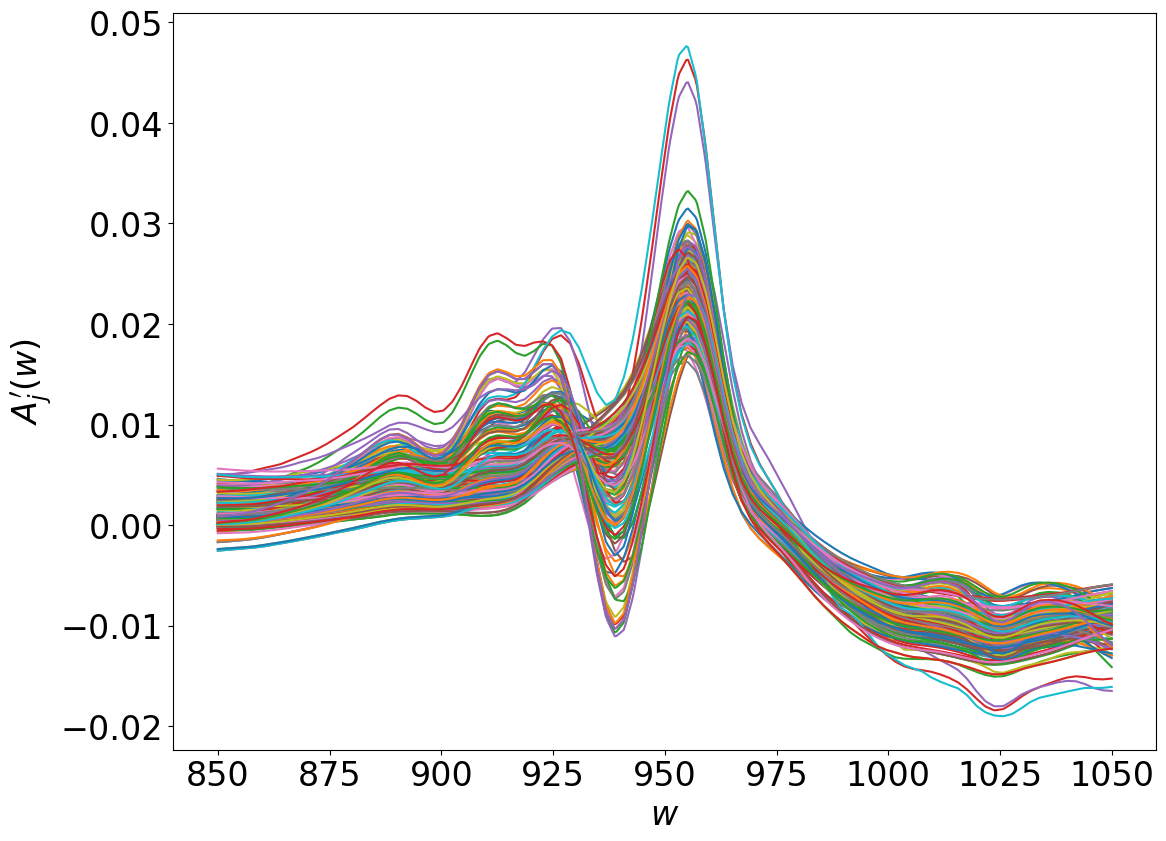

In [7]:
df = f.derivative()
zzz = df.plot()
zzz.axes[0].tick_params(axis='x', labelsize=24)
zzz.axes[0].tick_params(axis='y', labelsize=24)
zzz.axes[0].set_xlabel(r"$w$", fontsize=24)
zzz.axes[0].set_ylabel(r"$A_j'(w)$", fontsize=24)
zzz.figure.set_size_inches(new_size)
#left = zzz.axes[0].figure.subplotpars.left
#bottom = zzz.axes[0].figure.subplotpars.bottom
#print(left, bottom)
zzz.figure.subplots_adjust(left=1.3 * left)
zzz.figure.subplots_adjust(bottom=1.3 * bottom)
zzz.figure.set_facecolor("none")
zzz.axes[0].set_facecolor("white")
if save_figures:
    zzz.figure.savefig(os.path.join(images_path, "tecator_first_der_no_name.pdf"), format="pdf")

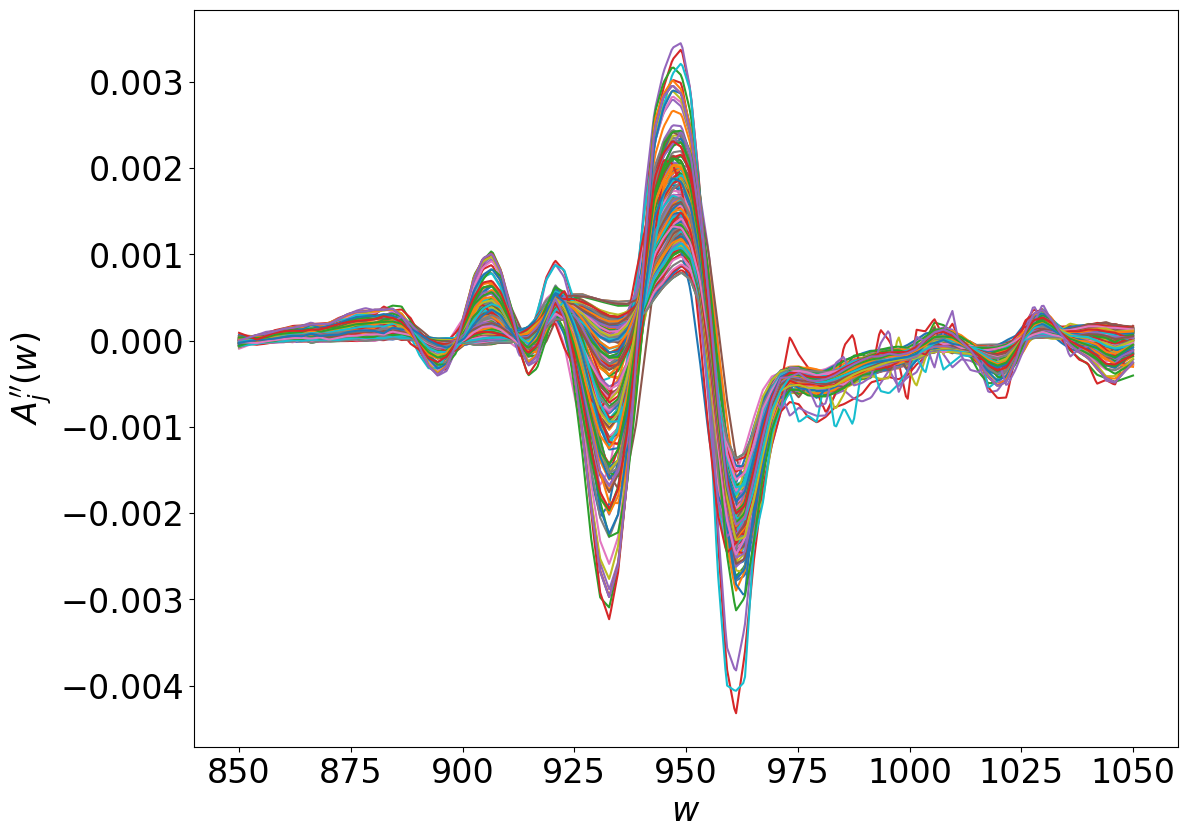

In [8]:
ddf = f.derivative(order=2)
zzz = ddf.plot()
zzz.axes[0].tick_params(axis='x', labelsize=24)
zzz.axes[0].tick_params(axis='y', labelsize=24)
zzz.axes[0].set_xlabel(r"$w$", fontsize=24)
zzz.axes[0].set_ylabel(r"$A_j''(w)$", fontsize=24)
zzz.figure.set_size_inches(new_size)
#left = zzz.axes[0].figure.subplotpars.left
#bottom = zzz.axes[0].figure.subplotpars.bottom
#print(left, bottom)
zzz.figure.subplots_adjust(left=1.3 * left)
zzz.figure.subplots_adjust(bottom=1.3 * bottom)
zzz.figure.set_facecolor("none")
zzz.axes[0].set_facecolor("white")
if save_figures:
    zzz.figure.savefig(os.path.join(images_path, "tecator_second_der_no_name.pdf"), format="pdf")

# Data treatment

In [9]:
domain_range = f.domain_range[0]
abscissa_points = np.array([x for x in f.grid_points])
abscissa_points = abscissa_points[0, :]
n_basis_representation = 31
basis_bsplines = BSplineBasis(
    n_basis=n_basis_representation,
    domain_range=domain_range
)
print(type(abscissa_points))
print(abscissa_points.shape)

<class 'numpy.ndarray'>
(100,)


(215, 100)
(128, 100)
(32, 100)
(55, 100)


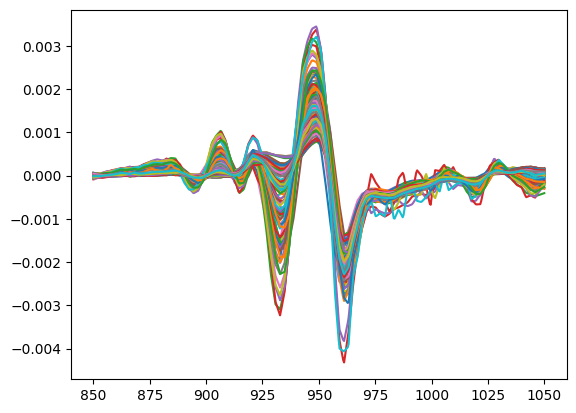

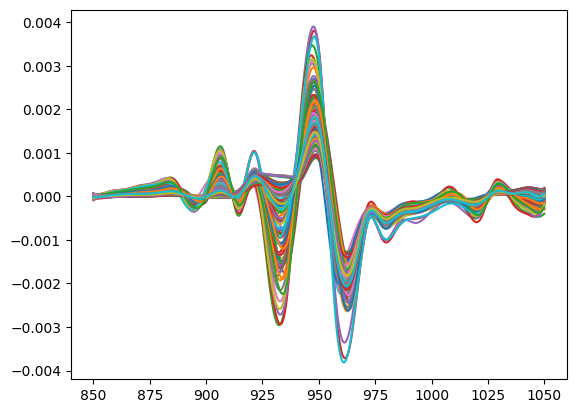

In [10]:
# Divide intro train, val and test
last_id_train_val = 160
rate_val = 0.2
# Get the data
#X_np = np.squeeze(ddf.data_matrix)
X_np = np.squeeze(ddf.data_matrix)
X_full = X_np[:last_id_train_val, :]
target_full = fat[:last_id_train_val]
X_train, X_validation, target_train, target_validation = train_test_split(
    X_full,
    target_full,
    test_size=rate_val,
    random_state=4
)

X_test = X_np[last_id_train_val:, :]
target_test = fat[last_id_train_val:]

# To Grid
X_train_grid = FDataGrid(X_train, f.grid_points)
X_validation_grid = FDataGrid(X_validation, f.grid_points)
X_test_grid = FDataGrid(X_test, f.grid_points)
X_full_grid = FDataGrid(X_full, f.grid_points)

# To basis
X_train_bspline = X_train_grid.to_basis(basis_bsplines)
X_validation_bspline = X_validation_grid.to_basis(basis_bsplines)
X_test_bspline = X_test_grid.to_basis(basis_bsplines)
X_full_bspline = X_full_grid.to_basis(basis_bsplines)

print(X_np.shape)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
zzz = X_full_grid.plot()
zzz = X_full_bspline.plot()

# Linear model

In [30]:
hyperopt_lm = HyperOptScikitFda(
    LinearRegression,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)
n_basis_list = list(range(4, 30, 1))
hist_lm = hyperopt_lm.search(
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation,
    basis=BSplineBasis,
    n_basis_list=n_basis_list,
)

In [31]:
best_score_lm_list = [x.best_score_ for x in hist_lm]
position_best_score_lm = np.argmax(best_score_lm_list)
best_n_basis_lm = n_basis_list[position_best_score_lm]
best_params_lm = hist_lm[position_best_score_lm].best_params_
best_model_lm = hyperopt_lm.cls_estimator(**best_params_lm)
best_basis_lm = BSplineBasis(
    n_basis=best_n_basis_lm,
    domain_range=domain_range,
)
X_full_bspline = X_full_grid.to_basis(best_basis_lm)
X_test_bspline = X_test_grid.to_basis(best_basis_lm)
_ = best_model_lm.fit(X_full_bspline, target_full)

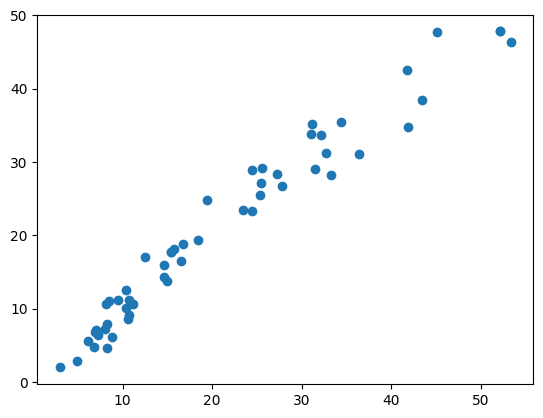

In [32]:
predicted_test_lm = best_model_lm.predict(X_test_bspline)
best_model_prediction_fn_np_lm = predict_from_np(
    grid_points=f.grid_points,
    domain_range=domain_range,
    basis=best_basis_lm,
    predict_fn=best_model_lm.predict,
)
predicted_test_lm = best_model_prediction_fn_np_lm(X_test)
plt.scatter(predicted_test_lm, target_test)

In [33]:
r2_test_lm = obtain_score(predicted_test_lm, target_test)
print(r2_test_lm)

0.9532660621151336


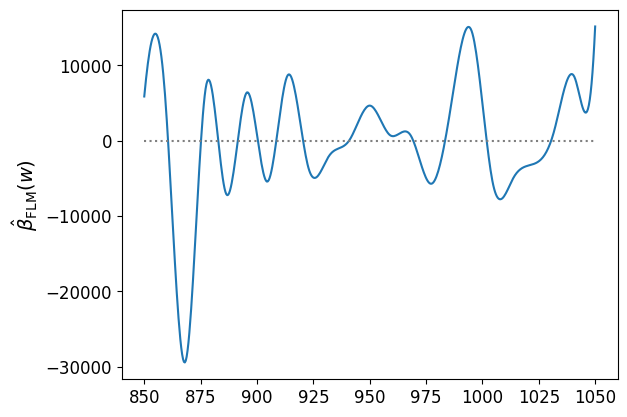

In [34]:
zzz = best_model_lm.coef_[0].plot()
zzz.axes[0].tick_params(axis='x', labelsize=12)
zzz.axes[0].tick_params(axis='y', labelsize=12)
zzz.axes[0].set_xlabel(r"$w$", fontsize=14)
zzz.axes[0].set_ylabel(r"$\hat{\beta}_\mathrm{FLM}(w)$", fontsize=14)
plt.hlines(
    0,
    850,
    1050,
    color="tab:grey",
    linestyle="dotted",
    #linewidths=3
)
plt.xlabel(f.argument_names[0])
if save_figures:
    plt.savefig(os.path.join(images_path, "tecator_raw_beta_lm.pdf"), format="pdf", bbox_inches='tight')

# KNN

In [35]:
hyperopt_knn = HyperOptScikitFda(
    KNeighborsRegressor,
    abscissa_points=abscissa_points,
    domain_range=domain_range,
)
hist_knn = hyperopt_knn.search(
    params={"n_neighbors": range(3, 30, 1)},
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation
)

In [36]:
best_score_knn_list = [x.best_score_ for x in hist_knn]
position_best_score_knn = np.argmax(best_score_knn_list)
best_params_knn = hist_knn[position_best_score_knn].best_params_
best_model_knn = hyperopt_knn.cls_estimator(**best_params_knn)
_ = best_model_knn.fit(X_full, target_full)

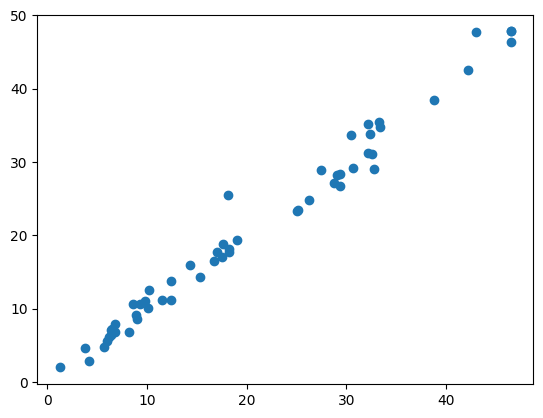

In [37]:
predicted_test_knn = best_model_knn.predict(X_test)
plt.scatter(predicted_test_knn, target_test)

In [38]:
r2_test_knn = obtain_score(predicted_test_knn, target_test)
print(r2_test_knn)

0.9801974088203131


# FNN

In [39]:
input_shape = (X_test.shape[1], 1)
filter_options = [
    {
        "n_filters": 20,
        "basis_options": {
            "n_functions": 7,
            "resolution": 25,
            "basis_type": "Legendre"
        },
        "activation": "elu"
    },
    {
        "n_filters": 5,
        "basis_options": {
            "n_functions": 7,
            "resolution": 25,
            "basis_type": "Legendre"
        },
        "activation": "elu"
    }
]
layer_options = [
    {
        "n_neurons": 1,
        "basis_options":
        {
            "n_functions": 1,
            "resolution": 52,
            "basis_type": "Fourier"
        },
        "activation": "elu",
        "pooling": True
    }
]
loss = "mse"
inputs = tf.keras.layers.Input(shape=input_shape)
norm_axes = list(range(len(input_shape) - 1))
layer = tf.keras.layers.LayerNormalization(
    axis=norm_axes,
    center=False,
    scale=False,
    epsilon=1e-10,
    name="Normalization"
)(inputs)

for i, filter_option in enumerate(filter_options):
    layer = FunctionalConvolution(
        **filter_option,
        name=f"FunctionalConvolution_{i}"
    )(layer)

for i, layer_option in enumerate(layer_options):
    layer = FunctionalDense(
        **layer_option,
        name=f"FunctionalDense_{i}"
    )(layer)

outputs = layer
#tf.keras.utils.set_random_seed(1234)
best_model_fnn = tf.keras.Model(inputs=inputs, outputs=outputs, name="Example_FNN")
best_model_fnn.summary()

Model: "Example_FNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Normalization                   │ (None, 100, 1)         │             0 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalConvolution_0         │ (None, 76, 20)         │           140 │
│ (FunctionalConvolution)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalConvolution_1         │ (None, 52, 5)          │           700 │
│ (FunctionalConvolution)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_0               │ (None, 1)              │             5 │
│ (FunctionalDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845 (3.30 KB)

 Trainable params: 845 (3.30 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
best_model_fnn.compile(loss=loss, optimizer="adam")
best_model_fnn.fit(
    X_train,
    target_train,
    epochs=600,
    validation_data=(X_validation, target_validation),
    batch_size=64,
    #steps_per_epoch=1000,
    verbose=0
)

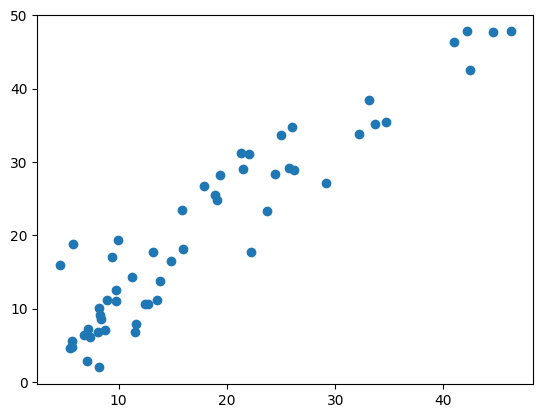

In [41]:
best_model_prediction_fn_squeeze_fnn = predict_no_verbose_squeeze(best_model_fnn.predict)
predicted_test_fnn = best_model_prediction_fn_squeeze_fnn(X_test)
plt.scatter(predicted_test_fnn, target_test)

In [42]:
r2_test_fnn = obtain_score(predicted_test_fnn, target_test)
print(r2_test_fnn)

0.8394079808883139


# Shapley

In [11]:
num_intervals = 20
num_permutations = 5000
save_shapley_file = False

In [ ]:
shapley_fda = ShapleyFda(
    X=X_test,
    abscissa_points=abscissa_points,
    target=target_test,
    domain_range=domain_range,
    verbose=False,
)
shapley_value = shapley_fda.compute_shapley_value(
    num_permutations=num_permutations,
    predict_fns=[
        best_model_prediction_fn_np_lm,
        best_model_knn.predict,
        best_model_prediction_fn_squeeze_fnn
    ],
    labels_fns=[
        "lm",
        "knn",
        "fnn"
    ],
    num_intervals=num_intervals,
    compute_mrmr_r2=True,
    compute_mrmr_distance_correlation=True,
)

if save_shapley_file:
    with open(os.path.join(data_output_path, f"real_dataset_shapley_{num_permutations}_{num_intervals}.pkl"), "wb") as fs_wb:
        pickle.dump(shapley_value, fs_wb)

# Plots

In [12]:
load_from_file = True

In [13]:
if load_from_file:
    with open(os.path.join(data_output_path, "real_dataset_shapley_5000_20.pkl"), "rb") as f_rb:
        shapley_value = pickle.load(f_rb)

In [14]:
shapley_value_normalised = shapley_value.copy()
main_keys = ["intervals", "middle_points"]
shapley_value_keys = shapley_value_normalised.keys()
max_val = -np.Inf
# Normalise distance correlation
for k in shapley_value_keys:
    if k == "mRMR_distance_correlation":
        val = shapley_value_normalised[k]
        total = np.sum(val)
        shapley_value_normalised[k] = np.multiply(val, total)
    if k != "mRMR_r2" and not k in main_keys:
        current_max = np.max(shapley_value_normalised[k])
        if current_max > max_val:
            max_val = current_max
# Adjust mRMR
val_r2 = shapley_value_normalised["mRMR_r2"]
shapley_value_normalised["mRMR_r2"] = np.multiply(val_r2, max_val/np.max(val_r2))

if "execution_time" in shapley_value_normalised.keys():
    del shapley_value_normalised["execution_time"]

In [15]:
translation_dict = {
    "fnn": "fnn",
    "knn": "fknn",
    "lm": "flm",
    "mRMR_distance_correlation": "distance_corr",
    "mRMR_r2": "mRMR",
}

In [16]:
print(shapley_value_normalised["intervals"])
print(shapley_value_normalised["fnn"])
print(np.argmax(shapley_value_normalised["fnn"]))
print(shapley_value_normalised["intervals"][np.argmax(shapley_value_normalised["fnn"])])
print(shapley_value_normalised["fnn"][np.argmax(shapley_value_normalised["fnn"])])
print(shapley_value_normalised["fnn"][-1])

[array([850., 860.]), array([860., 870.]), array([870., 880.]), array([880., 890.]), array([890., 900.]), array([900., 910.]), array([910., 920.]), array([920., 930.]), array([930., 940.]), array([940., 950.]), array([950., 960.]), array([960., 970.]), array([970., 980.]), array([980., 990.]), array([ 990., 1000.]), array([1000., 1010.]), array([1010., 1020.]), array([1020., 1030.]), array([1030., 1040.]), array([1040., 1050.])]
[0.037420200628456184, 0.039378340741067074, 0.05137012715008883, 0.043754642391254366, 0.04571015254539513, 0.04608396217841772, 0.044671675401634164, 0.04733890599553927, 0.061057705192920364, 0.05597551324953441, 0.05781351732255257, 0.019701908667209424, 0.008307201404542962, 0.042291298387902056, 0.02060963974471936, 0.05755485182418381, 0.04783180181549509, 0.048304626412021046, 0.05309605622697749, 0.0608618292812303]
8
[930. 940.]
0.061057705192920364
0.0608618292812303


### Shapley relevance functions

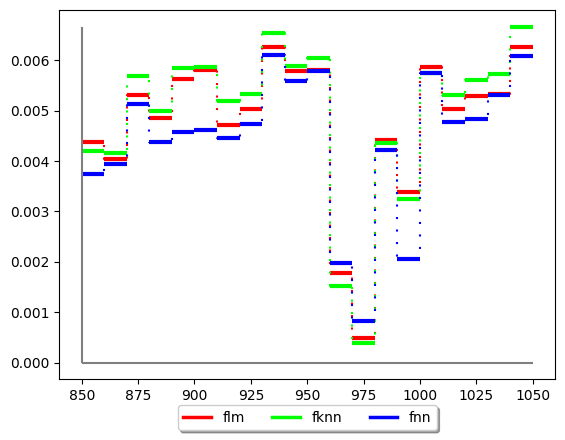

In [17]:
# Step function
plot_shapley_function(
    obj=shapley_value_normalised,
    domain_range=domain_range,
    translation_dict =translation_dict,
    plot_h_line=True,
    plot_v_line=True,
    disregard_feature_selection=True,
)
if save_figures:
    plt.savefig(
        os.path.join(images_path, f"tecator_step_fn_{num_permutations}_{num_intervals}.pdf"),
        format="pdf",
        bbox_inches="tight"
    )

In [18]:
y_max = 0
for k in shapley_value_normalised.keys():
    if not k in main_keys:
        current_max = np.max(shapley_value_normalised[k])
        if  current_max > y_max:
            y_max = current_max

894.4444 [890. 900.]
906.5657 [900. 910.]
932.8283 [930. 940.]
955.0505 [950. 960.]
1007.5758 [1000. 1010.]
1045.9596 [1040. 1050.]


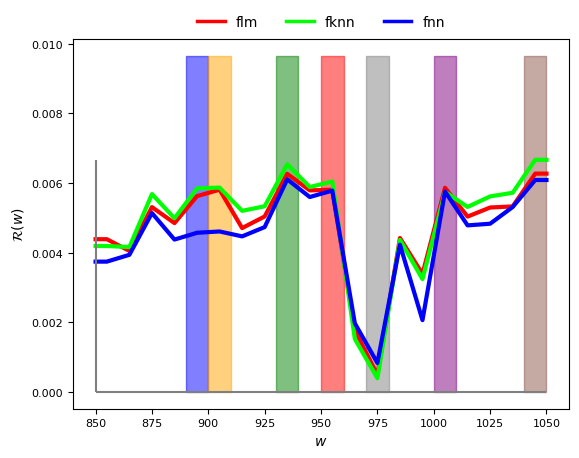

In [19]:
# Polygonal function
shapley_intervals = shapley_value_normalised["intervals"]
fig, ax = plt.subplots(1)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel(r"$w$", fontsize=10)
ax.set_ylabel(r"$\mathcal{R}(w)$", fontsize=10)
plot_shapley_value(
    obj=shapley_value_normalised,
    domain_range=domain_range,
    translation_dict =translation_dict,
    display_legend=True,
    display_legend_top=True,
    display_legend_below=False,
    disregard_feature_selection=True,
)
i = 0
idx_points = [22, 28, 41, 52, 78, 97]
special_interval = [970, 980]
special_x_point = 975
special_color = "grey"
color = ["blue", "orange", "green", "red", "purple", "tab:brown"]
for x in idx_points:
    current_abscissa = abscissa_points[x]
    i_interval = None
    for current_interval in shapley_intervals:
        if (current_interval[0] <= current_abscissa) and (current_interval[1] >= current_abscissa):
            i_interval = current_interval
    print(current_abscissa, i_interval)
    plt.fill_between(
        i_interval,
        0.00965,
        color=color[i],
        alpha=0.5,
    )
    i += 1

plt.fill_between(
        special_interval,
        0.00965,
        color=special_color,
        alpha=0.5,
    )
if save_figures:
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    plt.savefig(
        os.path.join(images_path, "tecator_shapley_value_5000_20.pdf"),
        format="pdf",
    )

In [ ]:
#save_figures = True

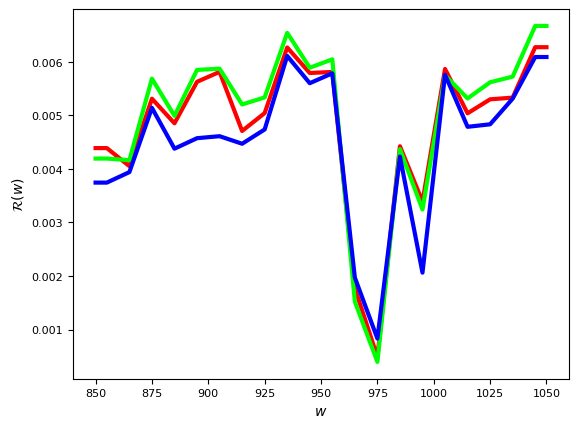

In [23]:
# Polygonal function
shapley_intervals = shapley_value_normalised["intervals"]
fig, ax = plt.subplots(1)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel(r"$w$", fontsize=10)
ax.set_ylabel(r"$\mathcal{R}(w)$", fontsize=10)
plot_shapley_value(
    obj=shapley_value_normalised,
    domain_range=domain_range,
    translation_dict =translation_dict,
    display_legend=False,
    display_legend_top=False,
    display_legend_below=False,
    disregard_feature_selection=True,
    plot_h_line=False,
    plot_v_line=False,
)
if save_figures:
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    plt.savefig(
        os.path.join(images_path, "tecator_shapley_value_5000_20_no_vlines.pdf"),
        format="pdf",
    )

### Tecator dataset

In [57]:
raw_data = f.copy()
second_der = f.derivative(order=2)
third_der =  f.derivative(order=3)
fourth_der = f.derivative(order=4)
fifth_der = f.derivative(order=5)

second_der.dataset_name = None
second_der_np = np.squeeze(second_der.data_matrix)
third_der_np = np.squeeze(third_der.data_matrix)
fourth_der_np = np.squeeze(fourth_der.data_matrix)
fifth_der_np = np.squeeze(fifth_der.data_matrix)

mean_second_der = np.mean(second_der_np, axis=0)
mean_third_der = np.mean(third_der_np, axis=0)
mean_fourth_der = np.mean(fourth_der_np, axis=0)
mean_fifth_der = np.mean(fifth_der_np, axis=0)
idx_arg_sort = np.argsort(mean_second_der)

In [58]:
raw_data.argument_names = None
raw_data.coordinate_names = None
raw_data.dataset_name = None
second_der.argument_names = None
second_der.coordinate_names = None
second_der.dataset_name = None

22 894.4444
28 906.5657
41 932.8283
52 955.0505
78 1007.5758
97 1045.9596


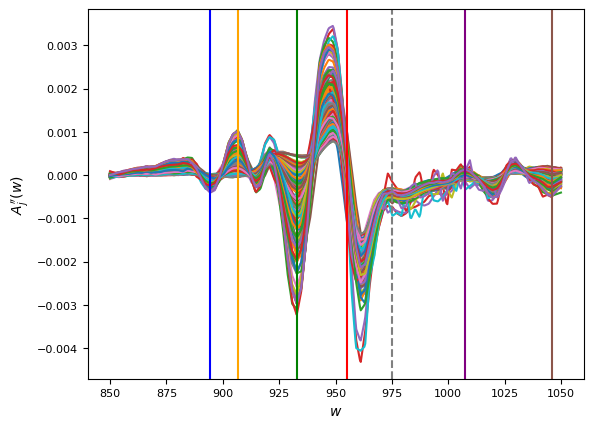

In [65]:
zzz = second_der.plot()
zzz.axes[0].tick_params(axis='x', labelsize=8)
zzz.axes[0].tick_params(axis='y', labelsize=8)
zzz.axes[0].set_xlabel(r"$w$", fontsize=10)
zzz.axes[0].set_ylabel(r"$A_j''(w)$", fontsize=10)

new_lim = zzz.axes[0].get_ylim()
i = 0
for x in idx_points:
    abs_p = abscissa_points[x]
    print(x, abs_p)
    plt.axvline(x=abs_p, color=color[i])
    i += 1

plt.axvline(x=special_x_point, color=special_color, linestyle="--")

if save_figures:
    zzz.figure.set_facecolor("none")
    zzz.axes[0].set_facecolor("white")
    plt.savefig(
        os.path.join(images_path, "tecator_second_der_vertical_lines.pdf"),
        format="pdf",
    )

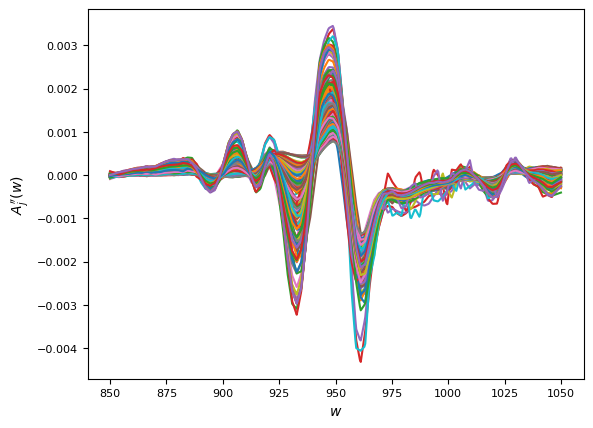

In [66]:
zzz = second_der.plot()
zzz.axes[0].tick_params(axis='x', labelsize=8)
zzz.axes[0].tick_params(axis='y', labelsize=8)
zzz.axes[0].set_xlabel(r"$w$", fontsize=10)
zzz.axes[0].set_ylabel(r"$A_j''(w)$", fontsize=10)

new_lim = zzz.axes[0].get_ylim()
if save_figures:
    zzz.figure.set_facecolor("none")
    zzz.axes[0].set_facecolor("white")
    plt.savefig(
        os.path.join(images_path, "tecator_second_der_no_vlines.pdf"),
        format="pdf",
    )

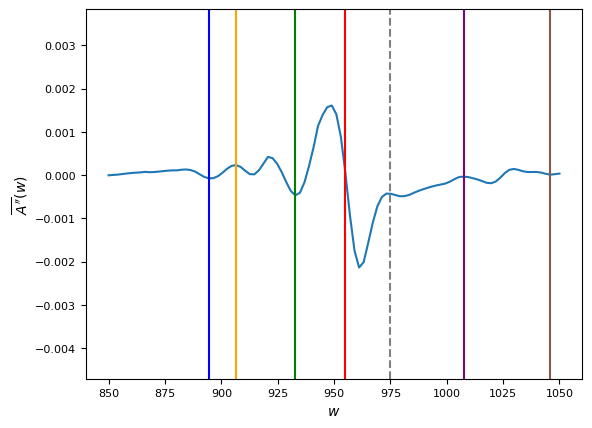

In [67]:
fig, ax = plt.subplots(1)
plt.plot(abscissa_points,mean_second_der.T)
plt.ylim(new_lim)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel(r"$w$", fontsize=10)
ax.set_ylabel(r"$\overline{A''}(w)$", fontsize=10)

i = 0
for x in idx_points:
    abs_p = abscissa_points[x]
    plt.axvline(x=abs_p, color=color[i])
    i += 1

plt.axvline(x=special_x_point, color=special_color, linestyle="--")

if save_figures:
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    plt.savefig(
        os.path.join(images_path, "tecator_second_der_mean.pdf"),
        format="pdf",
    )

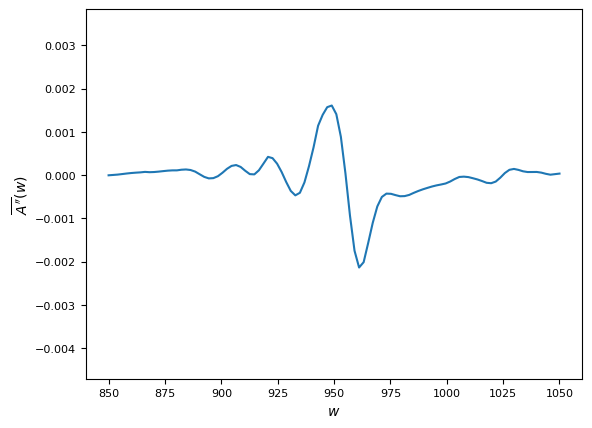

In [68]:
fig, ax = plt.subplots(1)
plt.plot(abscissa_points,mean_second_der.T)
plt.ylim(new_lim)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel(r"$w$", fontsize=10)
ax.set_ylabel(r"$\overline{A''}(w)$", fontsize=10)
if save_figures:
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    plt.savefig(
        os.path.join(images_path, "tecator_second_der_mean_no_vlines.pdf"),
        format="pdf",
    )